In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from g_ml.utilidades.processamento import treino_teste
from g_ml.utilidades.processamento import escala_padrao
from g_ml.utilidades.processamento import escala_min_max


from g_ml.utilidades.metricas import ACC
from g_ml.utilidades.metricas import MRE
from g_ml.utilidades.metricas import MSE
from g_ml.utilidades.metricas import MAE

from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(13)






## 1. MLP para regressão  


In [2]:
from sklearn.datasets import fetch_openml
concrete = fetch_openml(data_id='4353',as_frame=True)
X = concrete.data.iloc[:,0:8]
y = concrete.data.iloc[:,8]

In [3]:
X.head(2)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day)
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28.0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28.0


In [4]:
y.head(2)

0    79.99
1    61.89
Name: Concrete compressive strength(MPa. megapascals), dtype: float64

In [5]:
X = X.to_numpy()
y = y.to_numpy()

In [6]:
# Separação em treino e teste
X_treino, X_teste, y_treino, y_teste = treino_teste(X, y, tamanho_teste = 0.2)
# Seperação do treino em treino e validação → 25% para fechar em 60/20/20
X_treino_valid, X_teste_valid, y_treino_valid, y_teste_valid = treino_teste(X_treino, y_treino, tamanho_teste = 0.25)

In [7]:
# padronização da escala
escalador_X = escala_min_max()
escalador_y = escala_min_max()

escalador_X.fit(X_treino_valid)
escalador_y.fit(y_treino_valid)

X_treino_valid_escalado = escalador_X.transform(X_treino_valid)
X_teste_valid_escalado = escalador_X.transform(X_teste_valid)

y_treino_valid_escalado = escalador_y.transform(y_treino_valid)
y_teste_valid_escalado = escalador_y.transform(y_teste_valid)

y_treino_escalado = escalador_y.transform(y_treino)
y_teste_escalado = escalador_y.transform(y_teste)


In [8]:
# Funções usadas pela rede neural
def tanh(u):
    return (np.exp(2*u) - 1)/(np.exp(2*u) + 1)
def tanh_dif(u):
    return 1 - np.tanh(u)**2   
def relu(u):
    return np.maximum(0, u)
def relu_dif(u):
    return (u >= 0) * 1.0            
def afim(z):
    return z
def afim_dif(z):
    return np.ones(shape=z.shape)            
def sigmoid(z):
    return 1 / (1 + np.exp(-z))
def sigmoid_dif(z):
    return sigmoid(z) * (1 - sigmoid(z))             
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)[None,:]
def softmax_dif(z):
    return softmax(z) * (1 - softmax(z))

def custo_mse(true, pred):
    return np.mean((true - pred)**2)
def custo_logistico(true, pred):
    return np.mean(- true * np.log(pred) - (1 - true) * np.log(1 - pred))
def custo_softmax(true, pred):
    return - np.sum(true * np.log(pred)) / len(true)

def RMSE(true, pred):
    return np.sqrt(np.mean((true - pred)**2))

In [9]:
# implementação do modelo com 1 camada oculta 
class MLP_1L():
    def __init__(self, Nh=20, momentum=0.9, t=300, taxa=0.0001, 
                 tamanho_batch= 15, phi_1 = 'tanh', phi_2 = 'afim', custo = 'mse', reg = 0.1):
               
        self.t = t
        self.taxa = taxa
        self.B = tamanho_batch
        self.lamb = reg
                
        self.W = None
        self.M = None
        self.D = None
        self.Nh = Nh
        self.momentum = momentum
        self.K = 1
        
        self.atv_1 = phi_1
        self.atv_2 = phi_2
        self.phi_1 = None
        self.phi_2 = None
        self.custo = custo
        self.f_custo = None
        
        self.custos = []
        self.custos_val = []
        
        if self.atv_1 == 'tanh':
            self.phi_1 = np.tanh                
            self.phi_1_dif = tanh_dif                         
        if self.atv_1 == 'relu':
            self.phi_1 = relu                
            self.phi_1_dif = relu_dif                         
                      
        if self.atv_2 == 'afim':
            self.phi_2 = afim          
            self.phi_2_dif = afim_dif
            self.f_custo = custo_mse
            
        if self.atv_2 == 'sigmoid':
            self.phi_2 = sigmoid                
            self.phi_2_dif = sigmoid_dif
            self.f_custo = custo_logistico
        if self.atv_2 == 'softmax': 
            self.phi_2 = softmax                
            self.phi_2_dif = softmax_dif
            self.f_custo = custo_softmax          
        
    def fit(self, X, y, X_val, y_val):
        if self.atv_2 == 'softmax':
            self.K = len(np.unique(y))
        n = X.shape[0]
        X = np.c_[np.ones(X.shape[0]), X]
        X_val = np.c_[np.ones(X_val.shape[0]), X_val]
        y = y.reshape(-1,1) #Apenas para faciliar os cáculos
        y_val = y_val.reshape(-1,1)
        self.D = X.shape[1]
        # heurística para iniciar W e W_0 = 0
        self.W = np.random.normal(loc= 0, scale=1,size=(self.Nh,self.D)) * np.sqrt(1/self.D)
        self.W[:,0] = 0
        self.M = np.random.normal(loc= 0, scale=1,size=(self.K, self.Nh+1)) * np.sqrt(1/self.Nh+1)
        self.M[:, 0] = 0
        W_incremento_anterior = 0
        M_incremento_anterior = 0 
                               
        for epoca in range(self.t):
            
            # permutando os indices em cada época
            indice_aleatorio = np.random.permutation(len(y))
            X = X[indice_aleatorio]
            # Separando os indices de cada mini_batch, o último minibatch completa até o final
            index = np.arange(0, n, self.B)
            index[-1] = n
            # iterando em cada minibatch
            for i in range(len(index)-1):
                #---------Foward Pass-------------------
                # iterando em cada batch
                start = index[i]
                end = index[i+1]
                X_batch = X[start:end, : ]
                y_batch = y[start:end]
                Z = np.zeros([len(X_batch), self.Nh+1])
                
                Z[:, 0] = 1                            
                u = X_batch @ self.W.T
                Z[:, 1:] = self.phi_1(u)
                r = Z @ self.M.T
                pred = self.phi_2(r)
                #----- Backward Pass------------
                erro = y_batch - pred
                delta = erro * self.phi_2_dif(r)              
                zeta =  self.phi_1_dif(u) * (delta @ self.M[:, 1:])
                termo_M = self.lamb*self.M
                termo_M[:, 0] = 0
                self.M = self.M + self.taxa * (delta.T @ Z - termo_M) +  self.momentum * M_incremento_anterior
                M_incremento_anterior = self.taxa * (delta.T @ Z - termo_M)
                termo_W = self.lamb*self.W
                termo_W[:,0] = 0
                self.W = self.W + self.taxa * (zeta.T @ X_batch - termo_W) + self.momentum * W_incremento_anterior
                W_incremento_anterior = self.taxa * (zeta.T @ X_batch - termo_W)
                
                
                #----- Foward usando o X_treino inteiro para salvar o custo do treino ----
                
                Z = np.zeros([len(X), self.Nh+1])
                Z[:, 0] = 1                
                u = X @ self.W.T
                Z[:, 1:] = self.phi_1(u)
                r = Z @ self.M.T
                y_pred  = self.phi_2(r)                                 
                loss = self.f_custo(y, y_pred)/2
                
                
                self.custos.append(loss)
                
                #----- Foward usando o X_validação para salvar o custo da validação ----
                
                Z = np.zeros([len(X_val), self.Nh+1])
                Z[:, 0] = 1                
                u = X_val @ self.W.T
                Z[:, 1:] = self.phi_1(u)
                r = Z @ self.M.T
                y_pred_val  = self.phi_2(r)
                                 
                loss_val = self.f_custo(y_val, y_pred_val)/2
                self.custos_val.append(loss_val)
                
    def predict(self, X):
        
        X = np.c_[np.ones(X.shape[0]), X]        
        Z = np.zeros([len(X), self.Nh+1])
        Z[:, 0] = 1                
        u = X @ self.W.T
        Z[:, 1:] = self.phi_1(u)
        r = Z @ self.M.T
        y_pred  = self.phi_2(r)
        return y_pred
                
                
                
                               
                
                
                
                
                
        

In [10]:
grade = {
    'Nh':[15 , 35 ,50,100],
    'taxa':[0.0001 ,0.00001],
    'reg' : [0 ,0.01, 0.1, 0.25, 0.4]
    }

def BuscaAleatoria(modelo, grade, qtd, custo):
    """Cria n combinações únicas de parâmetros escolhida aleatóriamente na grade e avalia o desempenho
    de cada combinação para o modelo escolhido usando a métrica escolhida"""
    combinacoes = []
    

    while len(combinacoes) < qtd:
        a = {}
        for yi in grade.keys():
            a[yi] = np.random.choice(grade[yi])
            if a not in combinacoes:
                combinacoes.append(a)
                
    escores = []      
    for comb in combinacoes:
        model = modelo(**comb)
        model.fit(X_treino_valid_escalado, y_treino_valid_escalado, X_teste_valid_escalado, y_teste_valid_escalado)
        y_pred = model.predict(X_teste_valid_escalado)
        y_pred = escalador_y.inversa(y_pred)
        escores.append(custo(y_teste_valid, y_pred))
        print(comb)
        print(custo(y_teste_valid, y_pred))
        print("----")
        
    escores = np.array(escores)
    melhor_indice = np.argmin(escores)
    melhor = combinacoes[melhor_indice]
        
    return melhor, combinacoes, escores
        

### Buscando os melhores parâmetros usando o conjunto de validação


In [11]:
melhor, combinacoes, escores = BuscaAleatoria(MLP_1L, grade, 10, RMSE)

{'Nh': 35, 'taxa': 1e-05, 'reg': 0.0}
17.348160026174536
----
{'Nh': 35, 'taxa': 1e-05, 'reg': 0.4}
21.33984917265821
----
{'Nh': 35, 'taxa': 0.0001, 'reg': 0.4}
16.30822917585112
----
{'Nh': 50, 'taxa': 0.0001, 'reg': 0.25}
16.30897559600244
----
{'Nh': 15, 'taxa': 0.0001, 'reg': 0.01}
16.357573474415595
----
{'Nh': 15, 'taxa': 1e-05, 'reg': 0.25}
24.768334148056518
----
{'Nh': 50, 'taxa': 0.0001, 'reg': 0.01}
16.4117553906639
----
{'Nh': 35, 'taxa': 0.0001, 'reg': 0.1}
16.29475529238202
----
{'Nh': 35, 'taxa': 1e-05, 'reg': 0.1}
16.931354796786398
----
{'Nh': 15, 'taxa': 0.0001, 'reg': 0.01}
16.452301252792953
----


In [12]:
melhor

{'Nh': 35, 'taxa': 0.0001, 'reg': 0.1}

In [13]:
np.argmin(escores)

7

### Performance para o conjunto de validação

In [14]:
model = MLP_1L(**melhor)

model.fit(X_treino_valid_escalado, y_treino_valid_escalado, X_teste_valid_escalado, y_teste_valid_escalado)
y_pred = model.predict(X_teste_valid_escalado)
y_pred = escalador_y.inversa(y_pred)


mre = MRE(y_teste_valid, y_pred)
RMSE = np.sqrt(MSE(y_teste_valid, y_pred))
MAE = MAE(y_teste_valid, y_pred)

print("O erro relativo médio é: {}".format(mre))
print("A raiz do erro quadrático médio é: {}".format(RMSE))
print("O erro médio absoluto é: {}".format(MAE))


O erro relativo médio é: 0.5390563004607595
A raiz do erro quadrático médio é: 16.440200669120824
O erro médio absoluto é: 13.15587515764599


**Curva de aprendizagem para treino e validação**

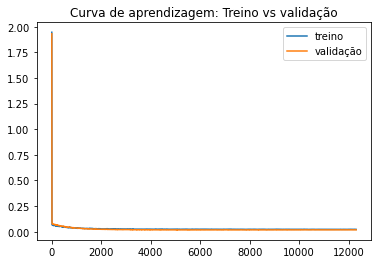

In [15]:
plt.plot(model.custos, label='treino')
plt.plot(model.custos_val, label='validação')
plt.title("Curva de aprendizagem: Treino vs validação")
plt.legend()

### Performance para o conjunto de treino

In [16]:
y_pred = model.predict(X_treino_valid_escalado)
y_pred = escalador_y.inversa(y_pred)


mre = MRE(y_treino_valid, y_pred)
RMSE = np.sqrt(MSE(y_treino_valid, y_pred))

print("O erro relativo médio é: {}".format(mre))
print("A raiz do erro quadrático médio é: {}".format(RMSE))


O erro relativo médio é: 0.6205468110880134
A raiz do erro quadrático médio é: 17.13604422788157


### Treinando o modelo usando treino e validação e avaliando no conjunto de teste

In [17]:
escalador_X.fit(X_treino)
escalador_y.fit(y_treino)

X_treino_escalado = escalador_X.transform(X_treino)
X_teste_escalado = escalador_X.transform(X_teste)

y_treino_escalado = escalador_y.transform(y_treino)
y_teste_escalado = escalador_y.transform(y_teste)

In [18]:
model = MLP_1L(**melhor)

model.fit(X_treino_escalado, y_treino_escalado, X_teste_escalado, y_teste_escalado)
y_pred = model.predict(X_teste_escalado)
y_pred = escalador_y.inversa(y_pred)


mre = MRE(y_teste, y_pred)
RMSE = np.sqrt(MSE(y_teste, y_pred))

print("O erro relativo médio é: {}".format(mre))
print("A raiz do erro quadrático médio é: {}".format(RMSE))


O erro relativo médio é: 0.6221740845856292
A raiz do erro quadrático médio é: 16.285827731178852


# 2. MLP para classificação (usando Sklearn)

In [19]:
from sklearn.datasets import fetch_openml
vowel = fetch_openml(data_id='307',as_frame=True)
X = vowel.data.iloc[:, 2:]
y = vowel.target

In [20]:
X.head(2)

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9
0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814
1,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488


In [21]:
# One hot encoding
import pandas as pd
y = pd.get_dummies(y, prefix='target')

In [22]:
y.head(2)

,target_hid,target_hId,target_hEd,target_hAd,target_hYd,target_had,target_hOd,target_hod,target_hUd,target_hud,target_hed
0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0


In [23]:
X = X.to_numpy()
y = y.to_numpy()

In [24]:
# Separação em treino e teste
X_treino, X_teste, y_treino, y_teste = treino_teste(X, y, tamanho_teste = 0.2)

In [25]:
# padronização da escala
escalador_X = escala_padrao()

escalador_X.fit(X_treino)

X_treino_escalado = escalador_X.transform(X_treino)
X_teste_escalado = escalador_X.transform(X_teste)

In [26]:
#instanciando o multilayer perceptron para classificação
model = MLPClassifier(activation= 'relu',momentum= 0.9, hidden_layer_sizes= (150,),
                      max_iter= 10000,solver='sgd', learning_rate='adaptive',batch_size=15)

In [27]:
# espaço de procura dos parâmetros
grid = {
    'hidden_layer_sizes':[(20,) , (50,) ,(150,), (220,), (300,)],
    'batch_size':[5, 10, 15, 25, 32],
    'learning_rate' : ['adaptive', 'constant', 'invscaling']
    }


In [28]:
#random search com o modelo no espaço de procura acima
rscv = RandomizedSearchCV(model, grid, cv= 4, verbose = 5, scoring='accuracy', n_jobs=-1,
                                    return_train_score = True, n_iter=7)

rscv.fit(X_treino_escalado, y_treino)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  28 out of  28 | elapsed: 15.4min finished


RandomizedSearchCV(cv=4,
                   estimator=MLPClassifier(batch_size=15,
                                           hidden_layer_sizes=(150,),
                                           learning_rate='adaptive',
                                           max_iter=10000, solver='sgd'),
                   n_iter=7, n_jobs=-1,
                   param_distributions={'batch_size': [5, 10, 15, 25, 32],
                                        'hidden_layer_sizes': [(20,), (50,),
                                                               (150,), (220,),
                                                               (300,)],
                                        'learning_rate': ['adaptive',
                                                          'constant',
                                                          'invscaling']},
                   return_train_score=True, scoring='accuracy', verbose=5)

In [29]:
# melhores parâmetros para o modelo
rscv.best_params_

{'learning_rate': 'adaptive', 'hidden_layer_sizes': (220,), 'batch_size': 10}

In [30]:
#Treinando modelo com todos os dados de treino
melhor_modelo = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes= (300,), batch_size = 5)
melhor_modelo.fit(X_treino_escalado, y_treino)
# avaliação do modelo nos dados de teste
y_pred = melhor_modelo.predict(X_teste_escalado)
acc = accuracy_score(y_teste, y_pred)
precisao = average_precision_score(y_teste, y_pred)
revocacao = recall_score(y_teste, y_pred, average='micro')
f1 = f1_score(y_teste, y_pred, average='micro')

print("A acurácia do modelo é de: {} ".format(acc))
print("A precisão do modelo é de: {}".format(precisao))
print("A revocacão do modelo é de: {}".format(revocacao))
print("O f1_score do modelo é de: {}".format(f1))


A acurácia do modelo é de: 0.9545454545454546 
A precisão do modelo é de: 0.9627995158575562
A revocacão do modelo é de: 0.9646464646464646
O f1_score do modelo é de: 0.9769820971867008


In [31]:
y_pred = melhor_modelo.predict(X_treino_escalado)
acc = accuracy_score(y_treino, y_pred)
precisao = average_precision_score(y_treino, y_pred)
revocacao = recall_score(y_treino, y_pred, average='micro')
f1 = f1_score(y_treino, y_pred, average='micro')

print("A acurácia do modelo é de: {} ".format(acc))
print("A precisão do modelo é de: {}".format(precisao))
print("A revocacão do modelo é de: {}".format(revocacao))
print("O f1_score do modelo é de: {}".format(f1))



A acurácia do modelo é de: 1.0 
A precisão do modelo é de: 1.0
A revocacão do modelo é de: 1.0
O f1_score do modelo é de: 1.0


Text(0.5, 1.0, 'Curva de aprendizagem no treino')

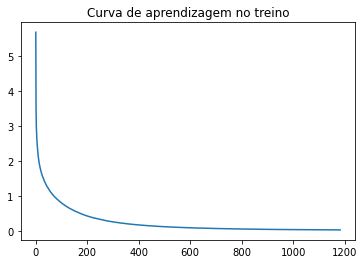

In [32]:
plt.plot(rscv.best_estimator_.loss_curve_)
plt.title('Curva de aprendizagem no treino')

Text(0.5, 1.0, 'Curva de aprendizagem no treino com todos os dados de treino')

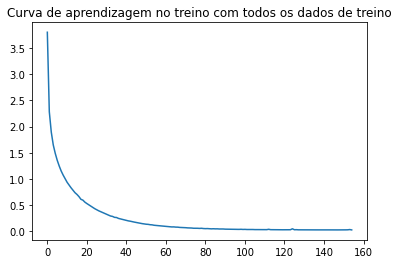

In [33]:
plt.plot(melhor_modelo.loss_curve_)
plt.title('Curva de aprendizagem no treino com todos os dados de treino')